## Diffusion Models & Diffusers

**Deep Learning with PyTorch** - 30/11/2022

_Univerisità degli Studi dell'Insubria_

_Edoardo Federici_ (edoardo.federici@zulla.it)

<center width="100%"><img src="images/gen_model.png" style="display: block; margin-left: auto; margin-right: auto;" width="150px"/></center>

In [1]:
import math
import random

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')
import seaborn as sns
sns.set()
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import sklearn.preprocessing as preprocessing
from PIL import Image, ImageEnhance

from dataclasses import dataclass
from typing import Dict

In [2]:
def plot_diffusion(q, dataset):
    _, axs = plt.subplots(1, 10, figsize=(28, 3))
    for i in range(10):
        q_i = q(dataset, torch.tensor([i * 10]))
        axs[i].scatter(q_i[:, 0], q_i[:, 1], s=4, c='gold');
        axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda


In [ ]:
!nvidia-smi

### Funzioni di attivazione

Per andare a valutare le differenze, definiamo una classe da cui i nostri moduli ereditano cose: 

In [4]:
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

In [5]:
class Sigmoid(ActivationFunction):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

class Tanh(ActivationFunction):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return (
            torch.exp(x) - torch.exp(-x)
        ) / (torch.exp(x) + torch.exp(-x))

class ReLU(ActivationFunction):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.max(torch.zeros_like(x), x)

class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.01):
        super().__init__()
        self.alpha = alpha

    def forward(self, x):
        return torch.max(self.alpha * x, x)

class GELU(ActivationFunction):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (
            1 + torch.tanh(
                math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))
            )
        )

class Swish(ActivationFunction):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

In [6]:
funzioni = {
    "sigmoid": Sigmoid(),
    "tanh": Tanh(),
    "relu": ReLU(),
    "leaky_relu": LeakyReLU(),
    "gelu": GELU(),
    "swish": Swish()
}

Un aspetto importante delle funzioni di attivazione è il modo in cui propagano i gradienti attraverso la rete. Immaginiamo di avere una rete neurale molto profonda con più di 50 layers. I gradienti per l'input layer, cioè il primo, sono passati per oltre 50 volte dalla funzione di attivazione, ma vogliamo comunque che siano di dimensioni ragionevoli. Se il gradiente attraverso la funzione di attivazione è molto più piccolo di 1, i nostri gradienti svaniranno fino a raggiungere l'input layer, causando il problema dei "vanishing gradients". Se il gradiente attraverso la funzione di attivazione è maggiore di 1, i gradienti aumentano esponenzialmente e potrebbero portare al cosiddetto problema degli "exploding gradients".

Il gradiente è importante nell'ottimizzazione della rete. PyTorch permette di calcolare i gradienti attraverso .backward()

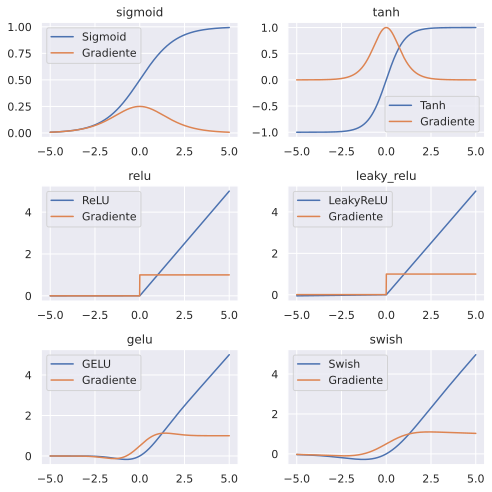

In [7]:
x = torch.linspace(-5, 5, 1000) 

def get_gradient(activation_function, x):
    input = x.clone().requires_grad_(True)
    output = activation_function(input)
    output.backward(torch.ones_like(output))
    return input.grad

def plot_activation(activation_function):
    y = activation_function(x)
    plt.plot(x, y, label=activation_function.name)
    plt.plot(x, get_gradient(activation_function, x), label="Gradiente")
    plt.legend()

def plot_activations(activation_functions: Dict[str, ActivationFunction]):
    n = len(activation_functions)
    cols = 2
    rows = math.ceil(n / cols)
    _, axs = plt.subplots(rows, cols, figsize=(7, 7))
    axs = axs.flatten()
    for i, (name, activation_function) in enumerate(activation_functions.items()):
        y = activation_function(x)
        axs[i].plot(x, y, label=activation_function.name)
        axs[i].plot(x, get_gradient(activation_function, x), label="Gradiente")
        axs[i].legend()
        axs[i].set_title(name)
    plt.tight_layout()
    plt.show()


plot_activations(funzioni)

### Inizializzazione

Come andiamo ad inizializzare la nostra rete?

Quando si inizializza una rete neurale, ci sono alcune proprietà che vorremmo avere. In primo luogo, la varianza in input dovrebbe essere propagata attraverso il modello fino all'ultimo layer, in modo da avere una deviazione standard simile per i neuroni in output. Se la varianza svanisce man mano che si va in profondità nel modello, diventa molto più difficile ottimizzarlo, poiché l'input al layer successivo è fondamentalmente un unico valore costante. Allo stesso modo, se la varianza aumenta, è probabile che esploda (cioè che arrivi all'infinito) quanto più in profondità progettiamo il nostro modello. La seconda proprietà che cerchiamo nelle tecniche di inizializzazione è una distribuzione del gradiente con una varianza uguale tra i layers. Se il primo layer riceve gradienti molto più piccoli rispetto all'ultimo layer, avremo difficoltà a scegliere un learning rate adeguato.

Come punto di partenza per trovare un buon metodo, analizzeremo diverse inizializzazioni basate sulla nostra rete senza funzione di attivazione (cioè ci mettiamo un'identità). Questo perché le inizializzazioni dipendono dalla specifica funzione di attivazione utilizzata nella rete e possiamo regolare gli schemi di inizializzazione in un secondo momento per la nostra scelta specifica.

In [10]:
class Embedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.weight = torch.randn((num_embeddings, embedding_dim))
        self.name = self.__class__.__name__
        
    def forward(self, x):
        return self.weight[x]


class Linear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()  
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.randn((in_features, out_features))
        self.bias = torch.randn(out_features) if bias else None
        self.name = self.__class__.__name__

    def forward(self, x):
        x = x @ self.weight
        if self.bias is not None:
            x += self.bias
        return x

class Sequential(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.name = self.__class__.__name__
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [8]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w

print(f"Media: {x.mean().numpy()}, Std: {x.std().numpy()}")
print(f"Media: {y.mean().numpy()}, Std: {y.std().numpy()}")

Media: 0.00643951864913106, Std: 1.004459261894226
Media: -0.006259322632104158, Std: 3.1048262119293213


In [11]:
lin = Linear(10, 200)

y = lin(x)

print(f"Media: {x.mean().numpy()}, Std: {x.std().numpy()}")
print(f"Media: {y.mean().numpy()}, Std: {y.std().numpy()}")

Media: 0.00643951864913106, Std: 1.004459261894226
Media: -0.06717289239168167, Std: 3.342979907989502


In [12]:
class Identity(nn.Module):
    def forward(self, x):
        return x

model = Sequential(
    nn.Linear(1024, 768),
    Identity(),
    nn.Linear(768, 768),
    Identity(),
    nn.Linear(768, 512),
    Identity(),
    nn.Linear(512, 256),
)

x = torch.randn(100, 1024, requires_grad=True)
label = torch.randn(100, 256)

In [13]:
def plot_weight_gradient_distribution(model, x, label, print_variance=False):
    model.eval()
    model.zero_grad()
    y = model(x)
    loss = F.mse_loss(y, label)
    loss.backward()

    grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
    model.zero_grad()

    _ = plot_dists(grads, color="C0", xlabel="Grad magnitude")
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key}, Varianza: {np.var(grads[key])}")


def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index % columns]
        # plottting
        sns.histplot(
            val_dict[key], 
            ax=key_ax, 
            color=color, 
            bins=50, 
            stat=stat,
            kde=use_kde and ((val_dict[key].max() - val_dict[key].min()) > 1e-8)
        )
        key_ax.set_title(
            f"{key} " + (r"(%i $\to$ %i)" % (
                val_dict[key].shape[1], 
                val_dict[key].shape[0]
            ) if len(val_dict[key].shape)>1 else ""))

        if xlabel is not None:
            key_ax.set_xlabel(xlabel)

        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

In [14]:
def constant_initialization(model, c=0.005):
    for _, param in model.named_parameters():
            param.data.fill_(c)

Qui proviamo ad inizializzare la rete con valori costanti. Questo vediamo che: 
- se settiamo a $0$ tutti il gradienti saranno $0$ quindi è inutile
- se invece usiamo valori piccoli, possiamo vedere che solo il primo e l'ultimo layer hanno una distribuzione dei gradienti decente, mentre per i layer interni notiamo che abbiamo gradiente unico per tutti i pesi. Questo vuol dire che avremo praticamente una riduzione dei nostri parametri da $n \rightarrow 1$. Non ottimale, diciamo.

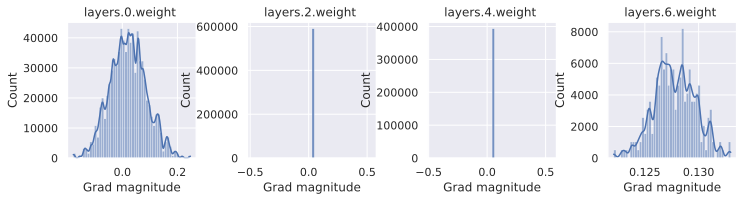

layers.0.weight, Varianza: 0.0043294657953083515
layers.2.weight, Varianza: 5.551115123125783e-17
layers.4.weight, Varianza: 1.249000902703301e-16
layers.6.weight, Varianza: 3.799889782385435e-06


In [15]:
constant_initialization(model)
plot_weight_gradient_distribution(model, x, label, print_variance=True)

Se inizializziassimo facendo sampling da una gaussiana, quindi definendo una deviazione standard? Abbiamo problemi con la varianza sulle attivazioni (che qui non vediamo) che va a diminuire fino a svanire. Con deviazione standard alta questa va ad "esplodere".

Dobbiamo comunque fare sampling da una distribuzione. Ma quale? Lo scegliamo rispetto alla distribuzione delle attivazioni. 
- la media delle attivazioni a 0
- la varianza delle attivazioni deve rimanere la stessa

Facendo calcoli vien fuori che la varianza deve essere:
$$Var(w_{i, j})=1/d_{x}$$

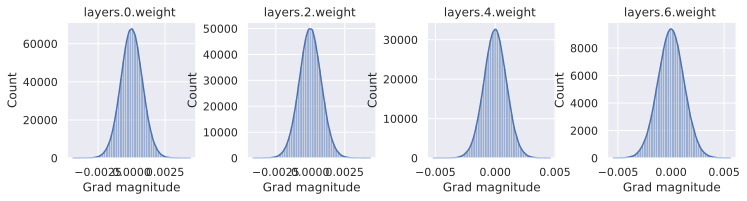

layers.0.weight, Varianza: 6.701799861730251e-07
layers.2.weight, Varianza: 6.549808517775091e-07
layers.4.weight, Varianza: 9.163695153802109e-07
layers.6.weight, Varianza: 1.5457029576282366e-06


In [16]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0/math.sqrt(param.shape[1]))

equal_var_init(model)
plot_weight_gradient_distribution(model, x, label, print_variance=True)

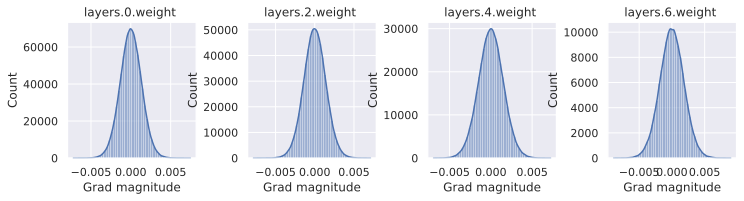

layers.0.weight, Varianza: 1.813545054574206e-06
layers.2.weight, Varianza: 1.9836618321278365e-06
layers.4.weight, Varianza: 2.273778591188602e-06
layers.6.weight, Varianza: 3.3773114864743548e-06


In [17]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6)/math.sqrt(param.shape[0] + param.shape[1])
            param.data.uniform_(-bound, bound)

xavier_init(model)
plot_weight_gradient_distribution(model, x, label, print_variance=True)

# Diffusion Models

I **denoising diffusion probabilistic models** (DDPMs) sono una nuova classe di modelli generativi che ha riscosso molto successo per la qualità delle generazioni in campo immagini. Il successo mediatico è dovuto a modelli come [DALL-E 2](https://openai.com/dall-e-2/) di OpenAI, [Imagen](https://imagen.research.google/) di Google Brain o Dall-e Mini. 

L'idea dei diffusion models, seppur si faccia riferimento al paper di ([Ho et al., 2020](https://arxiv.org/abs/2006.11239)), è stata introdotta già nel 2015: ([Sohl-Dickstein et al., 2015](https://arxiv.org/abs/1503.03585)), ma l'approccio è stato poi migliorato. 

Qui proveremo ad implementare un modello all'inizio non sulle immagini, per poi vedere come addestrare attraverso la libreria di Huggingface [Diffusers](). 

In [19]:
def exists(val):
    return val is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

L'idea non è così tanto complessa, come per Normalizing Flows, GANs etc. quello che si vuole è convertire rumore in data samples. La rete impara a togliere rumore dai dati partendo da puro rumore. 

In particolare abbiamo due fasi: la prima è quella del **forward**, in cui aggiungiamo gradualmente rumore Gaussiano ai dati ottenendo rumore, e una seconda fase **reverse** in cui una rete è addestrata a rimuovere il rumore per ottenere un'immagine o dati del nostro spazio dei dati.


<p align="center">
    <img src="https://drive.google.com/uc?id=1t5dUyJwgy2ZpDAqHXw7GhUAp2FE5BWHA" width="600" />
</p>

Entrambi i processi hanno bisogno di un numero \\(T\\) di steps (DDPM usa \\(T\\) = 1000). Si parte a $0$ con dati dal nostro dominio (volti, punti...) e nel forward campioniamo rumore e lo aggiungiamo.

Se \\(q(\mathbf{x}_0)\\) è la nostra distribuzione dei dati, possiamo prendere un'immagine, \\(\mathbf{x}_0 \sim q(\mathbf{x}_0)\\). Definiamo il processo forward \\(q(\mathbf{x}_t | \mathbf{x}_{t-1})\\) che aggiunge rumore Gaussiano ad ogni time step \\(t\\), secondo uno scheduling sulla varianza \\(0 < \beta_1 < \beta_2 < ... < \beta_T < 1\\)
$$
q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}). 
$$ (isotropica)

Una distribuzione normale (Gaussiana) è definita da media e varianza. Quindi, ogni nuovo campione a \\(t\\) è preso da una **distribuzione Gaussiana condizionata su quello precedente** con \\(\mathbf{\mu}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1}\\) e \\(\sigma^2_t = \beta_t\\), cosa possibile facendo \\(\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})\\) ed ottenendo \\(\mathbf{x}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1} +  \sqrt{\beta_t} \mathbf{\epsilon}\\). 

$$
q(x_{1:T}\vert x_{0}) := \prod_{t=1}^{T}q(x_{t}\vert x_{t-1}) :=\prod_{t= 1}^{T}\mathcal{N}(x_{t};\sqrt{1-\beta_{t}} x_{t-1},\ \beta_{t} \bf{I}) \\
$$

Per ottenere un sample al timestep `t`, abbiamo bisogno di iterare da `t0` a `t-1`, perché il sample ottenuto ad ogni timestep è condizionato dai samples dei timestep precedenti.

Non è affatto efficiente. Se ci sono 1000 steps e si desidera campionare il "999esimo" step bisogna iterare sull'intera catena di Markov. 

Come risolviamo?

### Riparametrizzazione

Sappiamo che la somma di gaussiane indipendenti è ancora una gaussiana. 

Possiamo sfruttarlo per campionare da uno step arbitrario. Tutto quello che dobbiamo fare è **_riparametrizzare_**.

&nbsp; $\alpha_{t} = 1 - \beta_{t},$ &nbsp; e &nbsp; $\bar{\alpha}_{t} = \prod_{i=1}^T \alpha_{i}$

Sappiamo che data:

$$
q(x_{1:T}\vert x_{0}) := \prod_{t=1}^{T}q(x_{t}\vert x_{t-1}) :=\prod_{t= 1}^{T}\mathcal{N}(x_{t};\sqrt{1-\beta_{t}} x_{t-1},\ \beta_{t} \bf{I}) \\
$$

$$
\text{o} \ \ q(x_{t}\vert x_{t-1}) = \mathcal{N}(x_{t};\sqrt{1-\beta_{t}} x_{t-1 },\ \beta_{t} \bf{I})
$$

Possiamo ottenere il campione al timestep `t` come:

$$
x_{t} = \sqrt{1 - \beta_{t}} x_{t-1} + \sqrt{\beta_{t}}\epsilon_{t-1} \ \ \text{dove} \ \ \epsilon_{t-1} \sim \mathcal{N}(0, \bf{I})
$$

Sostituendo $\beta$ con $\alpha$ nell'equazione precedente possiamo ottenere un campione al timestep `t` come:

$$
\begin{align*}
x_{t} &= \sqrt{\alpha_{t}} x_{t-1} + \sqrt{1 - \alpha_{t}}\epsilon_{t-1} \\
\Rightarrow x_{t} &= 
\sqrt{\alpha_{t}} \ \ \underbrace{(\sqrt{\alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_{t-1}}\epsilon_{t-2})}_{\text{( Expanding } x_{t-1})} + 
\sqrt{1 - \alpha_{t}}\epsilon_{t-1} \\ \\
&= \sqrt{\alpha_{t} \alpha_{t-1}} x_{t-2} + 
\underbrace{\sqrt{\alpha_{t}(1 - \alpha_{t-1})}\epsilon_{t-2}}_{\text{RV1}} + 
\underbrace{\sqrt{1 - \alpha_{t}}\epsilon_{t-1}}_{\text{RV2}} \\
\end{align*}
$$

I due termini, vale a dire RV1 e RV2 su RHS nell'equazione sopra, sono due variabili casuali distribuite **normalmente** con una media pari a zero e varianze $\alpha_{t}(1 - \alpha_{t-1})\ $, e $(1 - \alpha_{t})$ rispettivamente.

se abbiamo due distribuzioni gaussiane con valori medi $\mu_{1} , \mu_{2}$ e varianze $\sigma_{1}^2 , \sigma_{2}^2$ rispettivamente, allora la somma di queste due variabili è equivalente a un'altra variabile casuale con distribuzione normale $\mathcal{N}(\mu_{1} + \mu_{2}, \sigma_{1}^2 +\sigma_{2}^2)$. Applicando questo all'equazione sopra si ottiene:

$$
\begin{align*}
\Rightarrow x_{t} &= 
\sqrt{\alpha_{t} \alpha_{t-1}} x_{t-2} + 
\sqrt{\alpha_{t}(1 - \alpha_{t-1}) + 
(1 - \alpha_{t})}\bar{z}_{t-2} & \bar{z}_{t-2} \ \text {è la Gaussiana unita} \\
&= \sqrt{\alpha_{t} \alpha_{t-1}} x_{t-2} + 
\sqrt{1 - \alpha_{t} \alpha_{t-1}}\bar{z}_{t-2} \\
&= \ \ ... \\
x_{t}&= \sqrt{\bar{\alpha_{t}}} x_{0} + 
\sqrt{1 - \bar{\alpha_{t}}}\epsilon \ \  \ \text{ (siccome } \
\ \bar{\alpha}_{t} = \prod_{i=1}^T \alpha_{i})
\end{align*}
$$

$$
q(x_{t}\vert x_{0}) = \mathcal{N}(x_{t};\sqrt{\bar{\alpha_{t}}} x_{0},\ (1 - \bar{ \alpha_{t}}) \ \bf{I}) \tag {2}
$$

Ah! L'equazione sopra è carina. Data l'immagine originale, ora possiamo campionare in qualsiasi momento arbitrario senza simulare l'intera catena di Markov fino a quel passaggio. Prima di codificarlo, ricapitoliamo ciò che abbiamo fatto e ottenuto:

1. Abbiamo capito che nella formulazione originale, dobbiamo simulare la catena di Markov nel passaggio per il quale vogliamo campionare.
2. Abbiamo riparametrizzato $\beta$ in termini di $\alpha$
3. Questo "aggiornamento" porta a un'equazione con cui possiamo campionare in qualsiasi momento arbitrario


### Reverse

Se potessimo invertire il processo e campionare da: $$q(x_{t-1}\vert x_{t})$$ saremmo in grado di ricreare il vero sample avendo come input rumore. (Ma sorpresa: [non si può]())

Nota che se $\beta_{t}$ è abbastanza piccolo, $q(x_{t-1}\vert x_{t})$ sarà gaussiano anche lui. Sfortunatamente non possiamo stimarlo facilmente, perché per farlo dovremmo utilizzare l'intero dataset. Quindi per semplificarci la vita addestriamo un modello per approssimare le probabilità che ci servono.

$$ p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_\theta(\mathbf{x}_{t},t), \Sigma_\theta (\mathbf{x}_{t},t))$$

$$
p_{\theta}(x_{0:T}) 
:= p(x_{T}) \prod_{t=1}^T p_{\theta}(x_{t-1} | x_{t}) 
:= p(x_{T}) \prod_{t=1}^T \mathcal{N}(x_{t-1}; \mu_{\theta}(x_{t}, t), \Sigma_{\theta}(x_{t}, t)) \tag{3}
$$

Sappiamo che la probabilità di $x_{t-1}|x_{t}$ è calcolabile se condizionata su $x_{0}$. Possiamo, utilizzando la regola di Bayes, con alcuni calcoli, andare a parametrizzare la media di $q(x_{t-1}|x_{t}, x_0)$:

$$\tilde{\mu}_{t}(x_t, x_0) = \frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar{\alpha}_t}x_0$$

$$\tilde{\mu}_{t} = \frac{1}{\sqrt{\alpha}_{t}}(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_t)$$

Otteniamo quindi la possibilità di calcolare $x_{t-1}$:
$$x_{t-1} = \mathcal{N}(x_{t-1};\frac{1}{\sqrt{\alpha}_{t}}(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_{\theta}(x_t, t)), \Sigma_{\theta}(x_t, t))$$

### Loss

La loss originalmente era parecchio più complicata: 
Sulla parametrizzazione che abbiamo visto, che è quella di Ho et al. [[1]](#ref1), la loss viene ricondotta a 
$$
\mathcal{L}_{\text{simple}}=\mathbb{E}_{t, \mathbf{x}_{0},\mathbf{\epsilon}}\left[ \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right].
$$

La rete va a predire il rumore, invece che andare a calcolare la media. 

```python
def p_loss(model, x_0):
    bs = x_0.shape[0] 
    t = torch.randint(0, timesteps, size=(bs // 2 + 1,))
    t = torch.cat([t, timesteps - t - 1], dim=0)[:bs].long()
    
    a = extract(sqrt_alphas_cumprod, t, x_0)

    am1 = extract(sqrt_one_minus_alphas_cumprod, t, x_0)
    e = torch.randn_like(x_0)

    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()
```

Definiamo una classe 

In [20]:
def sigmoid_beta_schedule(timesteps, start=1e-5, end=1e-2):
    return torch.sigmoid(torch.linspace(-6, 6, timesteps)) * (end - start) + start

def linear_beta_schedule(timesteps, start=1e-5, end=1e-2):
    return torch.linspace(start, end, timesteps)


class GaussianDiffusion(nn.Module):
    def __init__(self, model, timesteps, loss_type="l2", beta_schedule="sigmoid"):
        super().__init__()
        self.model = model
        self.timesteps = timesteps
        self.loss_type = loss_type

        if beta_schedule == "sigmoid":
            betas = sigmoid_beta_schedule(timesteps)
        elif beta_schedule == "linear":
            betas = linear_beta_schedule(timesteps)
        else:
            raise ValueError(f"Unknown beta_schedule: {beta_schedule}")

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))
        register_buffer("betas", betas)

        alphas = 1. - betas
        register_buffer("alphas", alphas)
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        register_buffer("alphas_cumprod", alphas_cumprod)

        alphas_cumprod_prev = torch.cat([torch.ones(1, dtype=torch.float32), self.alphas_cumprod[:-1]])
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

        register_buffer("alphas_cumprod_prev", alphas_cumprod_prev)
        register_buffer("sqrt_alphas_cumprod", sqrt_alphas_cumprod)
        register_buffer("sqrt_one_minus_alphas_cumprod", sqrt_one_minus_alphas_cumprod)

        posterior_mean_coef1 = (betas * torch.sqrt(alphas_cumprod) / (1 - alphas_cumprod))
        posterior_mean_coef2 = (
            (1 - alphas_cumprod_prev) * torch.sqrt(alphas) / (1 - alphas_cumprod)
        )

        register_buffer("posterior_mean_coef1", posterior_mean_coef1)
        register_buffer("posterior_mean_coef2", posterior_mean_coef2)

        posterior_var = betas * (1 - alphas_cumprod_prev) / (1 - alphas_cumprod)
        post_log_var_clipped = torch.log(
            torch.cat((posterior_var[1].view(1, 1), posterior_var[1:].view(-1, 1)), 0)
        ).view(-1)
        register_buffer('posterior_variance', posterior_var)
        register_buffer('posterior_log_variance_clipped', post_log_var_clipped)

    
    def q_sample(self, x_0, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_0))
        noised = (
                extract(self.sqrt_alphas_cumprod, t, x_0) * x_0 +
                extract(self.sqrt_one_minus_alphas_cumprod, t, x_0) * noise
        )
        return noised
     
    def q_posterior(self, x_0, x_t, t):
        # non usato
        posterior_mean = (
                extract(self.posterior_mean_coef1, t, x_t) * x_0 +
                extract(self.posterior_mean_coef2, t, x_t) * x_t
        )
        posterior_variance = extract(self.post_log_var_clipped, t, x_0)
        return posterior_mean, posterior_variance

    @torch.no_grad()
    def p_sample(self, x, t):
        t = torch.tensor([t])
    
        eps_factor = ((1 - extract(self.alphas, t, x)) / extract(self.sqrt_one_minus_alphas_cumprod, t, x))
        eps_theta = self.model(x, t)
        
        mean = (1 / extract(self.alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
        z = torch.randn_like(x)
        
        # sigma fissa
        sigma_t = extract(self.betas, t, x).sqrt()
        sample = mean + sigma_t * z
        return (sample)

    @torch.no_grad()
    def sample(self, shape):
        """
        Campiona per t = 0, ..., T
        """
        device = self.betas.device
        cur_x = torch.randn(shape, device=device)
        x_seq = [cur_x]
        for i in reversed(range(self.timesteps)):
            cur_x = self.p_sample(cur_x, i)
            x_seq.append(cur_x)
        return x_seq
    
    @property
    def loss_fn(self):
        if self.loss_type == 'l1':
            return F.l1_loss
        elif self.loss_type == 'l2':
            return F.mse_loss
        else:
            raise ValueError(f'invalid loss type {self.loss_type}')

    def p_loss(self, x_0, t, noise=None):
        # come q_sample
        noise = default(noise, lambda: torch.randn_like(x_0))
        noised = (
                extract(self.sqrt_alphas_cumprod, t, x_0) * x_0 +
                extract(self.sqrt_one_minus_alphas_cumprod, t, x_0) * noise
        )
        output = self.model(noised, t)
        return self.loss_fn(noise, output)

    def forward(self, x):
        b = x.shape[0] 
        t = torch.randint(0, self.timesteps, size=(b // 2 + 1,))
        t = torch.cat([t, self.timesteps - t - 1], dim=0)[:b].long()
        return self.p_loss(x, t)

### EMA

Questa idea si ritrova nella maggior parte delle implementazioni, che permettono di attuare una forma di momentum sul modello. Manteniamo una copia dei valori precedenti dei pesi e quindi aggiorniamo facendo media tra la versione precedente e quella nuova dei pesi, invece di aggiornarli normalmente. In questo caso, riutilizziamo l'implementazione proposta nel repository DDIM.

In [21]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

### Dataset 

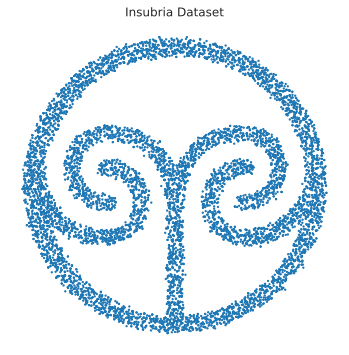

In [22]:
min_max_scaler = preprocessing.MinMaxScaler((-1.5, 1.5))

def get_data(x, n=1000):
    mu, sigma = 0., 0.05
    noise = np.random.normal(mu, sigma, x.shape)
    x_n = x + noise * 0.3
    noise = np.random.normal(mu, sigma, x.shape)
    x_n = np.concatenate((x_n, x + noise * 0.2), axis=0)
    x_n = x_n[np.random.choice(x_n.shape[0], n, replace=True), :]
    return x_n

def to_scatterplot(path):
    a = Image.open(path).convert('L')
    enhancer = ImageEnhance.Contrast(a)
    a = enhancer.enhance(1.9)

    b = Image.blend(a, Image.new(a.mode, a.size, "white"), .95).convert(mode="1")
    df = pd.DataFrame(
        ((x, -y) for x in range(b.width) for y in range(b.height) if not b.getpixel((x,y))), 
        columns=("x","y")
    )
    x_scaled = min_max_scaler.fit_transform(df.values.astype(float))

    return pd.DataFrame(
        get_data(x_scaled, 10000),
    )

df = to_scatterplot("images/uninsubria.jpg")
df.to_csv("data.csv", index=False)
df.plot.scatter(
    x=0, y=1, s=2, 
    c="#1f77b4", 
    figsize=(6, 6),
    title="Insubria Dataset",
).axis('off');

In [23]:
values = df.values.tolist()
random.shuffle(values)
data_img = np.array(values)
data_img = data_img.transpose(1, 0)

In [24]:
dataset = torch.tensor(data_img.T).float()
print(dataset.shape)

torch.Size([10000, 2])


### Training

In [25]:
class LinearScheduler(object):
    def __init__(self, optimizer, lr, n_iter):
        self.optimizer = optimizer
        self.lr = lr
        self.n_iter = n_iter
        self.n = 0

    def step(self):
        self.n += 1
        lr = self.lr * (1. - self.n / self.n_iter)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

In [26]:
class Trainer(object):
    def __init__(
        self, model, dataset, lr=1e-2, scheduler="linear", max_steps=1500, batch_size=128):
        super().__init__()
        
        self.model = model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.scheduler = LinearScheduler(self.optimizer, lr, max_steps) if scheduler == "linear" else None
        self.dataset = dataset 
        self.max_steps = max_steps
        self.bs = batch_size
        self.ema = EMA(0.9)
        self.ema.register(self.model)
        self.losses = list()

    def run(self):
        print("Training...")
        print(f" - Max steps: {self.max_steps}")
        print(f" - Batch size: {self.bs}")
        print(f" - Learning rate: {self.optimizer.param_groups[0]['lr']}")
        print(f" - Timesteps: {self.model.timesteps}")

        p_bar = tqdm(range(self.max_steps))
        for i in p_bar:
            permutation = torch.randperm(self.dataset.size()[0])
            running_loss = 0.0
            for _ in range(0, self.dataset.size()[0], self.bs):
                indices = permutation[i:i + self.bs]
                batch_x = dataset[indices]

                loss = self.model(batch_x)
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.)

                self.optimizer.step()
                self.ema.update(self.model)
                running_loss += loss.item() * self.bs

            step_loss = running_loss / self.dataset.size()[0]
            self.losses.append(step_loss)

            if self.scheduler is not None:
                self.scheduler.step()
                
            p_bar.set_description(f"Loss: {step_loss:.4f}")
            
        print("Finished Training")

    def plot_losses(self, factor=0.8):
        def smooth_curve(points, factor):
            smoothed_points = []
            for point in points:
                if smoothed_points:
                    previous = smoothed_points[-1]
                    smoothed_points.append(previous * factor + point * (1 - factor))
                else:
                    smoothed_points.append(point)
            return smoothed_points
        
        sns.lineplot(data=smooth_curve(self.losses, factor))
        plt.title(f"Losses, factor={factor}")
        plt.show()

In [27]:
@dataclass
class TrainingArgs:
    batch_size = 128
    timesteps = 100
    lr=5e-3
    max_steps=1500
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = TrainingArgs()

In [28]:
class ConditionalLinear(nn.Module):
    def __init__(self, n_in, n_out, n_steps):
        super(ConditionalLinear, self).__init__()
        
        self.n_out = n_out
        self.lin = nn.Linear(n_in, n_out)
        self.emb = nn.Embedding(n_steps, n_out)
        self.emb.weight.data.uniform_()
        self.name = self.__class__.__name__

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.emb(y)
        out = gamma.view(-1, self.n_out) * out
        return out

class BabyModel(nn.Module):
    def __init__(self, n_in, n_out, n_steps, act, hidden_sizes=[64, 128, 128, 64]):
        super(BabyModel, self).__init__()

        self.n_steps = n_steps
        self.n_in = n_in
        self.n_out = n_out
        self.act = act

        layers = []
        layer_sizes = [n_in] + hidden_sizes
        for i in range(len(layer_sizes) - 1):
            layers.append(ConditionalLinear(layer_sizes[i], layer_sizes[i + 1], n_steps))
            layers.append(act())
        layers.append(nn.Linear(layer_sizes[-1], n_out))
        self.model = nn.ModuleList(layers)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        for i, layer in enumerate(self.model):
            if isinstance(layer, ConditionalLinear):
                x = layer(x, t)
            else:
                x = layer(x)
        return x

In [29]:
model = BabyModel(
    n_in=2,
    n_out=2,
    n_steps=args.timesteps,
    act=ReLU
).to("cpu")

diffusion = GaussianDiffusion(
    model=model,
    timesteps=args.timesteps,
    loss_type="l2",
).to("cpu")

trainer = Trainer(
    model=diffusion,  
    dataset=dataset, 
    lr=args.lr,
    scheduler="linear",
    max_steps=args.max_steps,
    batch_size=args.batch_size
)

In [ ]:
img = Image.open('uninsubria.jpg')
img = img.resize((256, 256))
img = np.array(img)
img = torch.tensor(img).unsqueeze(0).float() / 255

x = img
sample_steps = [0, 10, 40, 70, 99]

fig, axs = plt.subplots(1, len(sample_steps), figsize=(15, 3))

for ax in axs:
    ax.grid(False)
    ax.axis('off')

for i in range(len(sample_steps)):
    t = torch.tensor([sample_steps[i]])
    x_t = diffusion.q_sample(x, t)
    x_t = x_t.squeeze().detach().numpy()
    x_t = np.clip(x_t, 0, 1)
    axs[i].imshow(x_t)
    axs[i].set_title(f"t = {sample_steps[i]}")

plt.show()

In [ ]:
plot_diffusion(diffusion.q_sample, dataset)

In [ ]:
trainer.run()

In [ ]:
trainer.plot_losses()

In [ ]:
samples = diffusion.sample([7000, 2])

fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(1, 11):
    cur_x = samples[i * 10].detach()
    axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=4, c='gold')
    axs[i-1].set_axis_off(); axs[i-1].set_title('$q(\mathbf{x}_{'+str(i * args.timesteps // 10)+'})$')

<center width="100%"><img src="images/inference.png" style="display: block; margin-left: auto; margin-right: auto;" width="800px"/></center>

<a id="ref1"/>

[1] [Ho, J., Jain, A., & Abbeel, P. (2020). _Denoising diffusion probabilistic models_. arXiv preprint arXiv:2006.11239.](https://arxiv.org/pdf/2006.11239)

<a id="ref2"/>

[2] [Weng, Lilian. (2021). _What are diffusion models?_.](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)

<a id="ref3"/>

[3] [Patrick von Platen and Suraj Patil and Anton Lozhkov and Pedro Cuenca and Nathan Lambert and Kashif Rasul and Mishig Davaadorj and Thomas Wolf. (2022). _Diffusers: State-of-the-art diffusion models_.](https://github.com/huggingface/diffusers/)

### Diffusers

In [ ]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

In [ ]:
@dataclass
class DiffusersArgs:
    image_size = 128
    batch_size = 8
    dataset = "huggan/few-shot-universe" # "huggan/pokemon", "huggan/few-shot-universe"
    split = "train"
    
args = DiffusersArgs()

In [ ]:
preprocess = transforms.Compose(
    [
        transforms.Resize((args.image_size, args.image_size)),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

In [ ]:
dataset = load_dataset(args.dataset, split=args.split)
dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=args.batch_size, shuffle=True
)

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(
    num_train_timesteps = 1000,
    beta_schedule = "squaredcos_cap_v2"
)

In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size = args.image_size,
    in_channels = 3,
    out_channels = 3,
    layers_per_block = 2,
    block_out_channels = (64, 128, 128, 256),
    down_block_types = (
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types = (
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    )
)
model.to(device)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = list()                    
for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
 
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad()

    loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

In [ ]:
from diffusers import DDPMPipeline 

pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [ ]:
pipeline_output = pipeline()

In [ ]:
plt.imshow(pipeline_output.images[0], interpolation='nearest')
plt.axis('off')
plt.show()

# Stable Diffusion



In [1]:
import matplotlib.pyplot as plt

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

repo_id = "runwayml/stable-diffusion-v1-5"
device="cuda"

pipe = StableDiffusionPipeline.from_pretrained(repo_id, revision="fp16", torch_dtype=torch.float16)
pipe = pipe.to(device)

  0%|          | 0/50 [00:00<?, ?it/s]

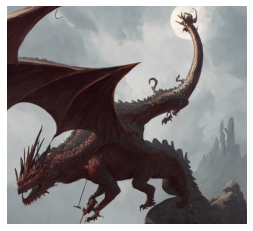

In [4]:
prompt = "A dragon by Greg Rutkowski, 8k, trending on artstation"
image = pipe(prompt, width=704, height=640, guidance_scale=7).images[0]
image.save("dragon.png")
plt.imshow(image)
plt.axis('off')
plt.show()